# TACO dataset: Exploratie

## Probleemstelling

Bron: [http://tacodataset.org/](http://tacodataset.org/)  
  

> Humans have been trashing planet Earth from the bottom of Mariana trench to Mount Everest. Every minute, at least 15 tonnes of plastic waste leak into the ocean, that is equivalent to the capacity of one garbage truck. We have all seen the impact of this behaviour to wildlife on images of turtles choking on plastic bags and birds filled with bottle caps. Recent studies have also found microplastics in human stools. These should be kept in the recycling chain not in our food chain. It is time for a revolution.  
>   
> We believe AI has an important role to play. Think of drones surveying trash, robots picking up litter, anti-littering video surveillance and AR to educate and help humans to separate trash. That is our vision. All of this is now possible with the recent advances of deep learning. ...



In [1]:
import glob
import os
import random
from pprint import pprint

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import yaml
from PIL import Image, ImageDraw

# Dataset

In [2]:
# Download the dataset
path = kagglehub.dataset_download("vencerlanz09/taco-dataset-yolo-format")

print(path)

/home/user/.cache/kagglehub/datasets/vencerlanz09/taco-dataset-yolo-format/versions/1


# Data exploratie
## README's

In [3]:
with open(path + "/README.dataset.txt") as f:
    print(f.read())

# TACO > YOLOv5
https://universe.roboflow.com/divya-lzcld/taco-mqclx

Provided by a Roboflow user
License: CC BY 4.0




In [4]:
with open(path + "/README.roboflow.txt") as f:
    print(f.read())


TACO - v3 YOLOv5

This dataset was exported via roboflow.com on January 26, 2023 at 2:58 PM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand and search unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

For state of the art Computer Vision training notebooks you can use with this dataset,
visit https://github.com/roboflow/notebooks

To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com

The dataset includes 6004 images.
Litter are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 416x416 (Stretch)

The following augmentation was applied to create 2 versions of each source image:
* 50% probability of horizo

## Annotatie format
The annotations are in YOLOv8 format. The documentation is available from the roboflow website: [https://roboflow.com/formats/yolov8-pytorch-txt](https://roboflow.com/formats/yolov8-pytorch-txt).

## Meta data

In [5]:
with open(path + "/data.yaml") as f:
    meta = yaml.safe_load(f)

# yaml is loaded as a dictionary; using p(retty)print for a nicer output
pprint(meta)

{'names': ['Aluminium foil',
           'Bottle cap',
           'Bottle',
           'Broken glass',
           'Can',
           'Carton',
           'Cigarette',
           'Cup',
           'Lid',
           'Other litter',
           'Other plastic',
           'Paper',
           'Plastic bag - wrapper',
           'Plastic container',
           'Pop tab',
           'Straw',
           'Styrofoam piece',
           'Unlabeled litter'],
 'nc': 18,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'taco-mqclx',
              'url': 'https://universe.roboflow.com/divya-lzcld/taco-mqclx/dataset/3',
              'version': 3,
              'workspace': 'divya-lzcld'},
 'test': '../test/images',
 'train': '../train/images',
 'val': '../valid/images'}


In [6]:
# the path to the images needs to be updated
# os.listdir(meta["train"]) # this generates a FileNotFoundError

meta["train"] = path + "/train/images"
meta["val"] = path + "/valid/images"
meta["test"] = path + "/test/images"

# show the first five image files
os.listdir(meta["train"])[:5]

['000055_jpg.rf.c6469959ba228f5f911bde1600d6aff1.jpg',
 '000087_JPG_jpg.rf.71ce4fddda8e920b59379c35e8618a5e.jpg',
 '000034_jpg.rf.35a8006a0042c68aa5954c6d64a9318f.jpg',
 '000086_jpg.rf.8c02a463d47c95b3bba22d7d44d01ed2.jpg',
 '000073_jpg.rf.9fbe4f1aea5e6e5f44cfcb000b6d9358.jpg']

## Pandas DataFrame
We create a DataFrame to explore the training, validation and test data.  
Each image has a `images/*.jpg` and `labels/*.txt` counterpart.  
We first compile a list of all the images so we can read in the corresponding label files.

In [7]:
img_paths = glob.glob(path + "/**/*.jpg", recursive=True)
img_paths[:5]

['/home/user/.cache/kagglehub/datasets/vencerlanz09/taco-dataset-yolo-format/versions/1/test/images/000022_jpg.rf.e33fcd57a3224c626b7cc860963250cb.jpg',
 '/home/user/.cache/kagglehub/datasets/vencerlanz09/taco-dataset-yolo-format/versions/1/test/images/000000_jpg.rf.c74a32a1e0ac35591aa5f3279b58ee6f.jpg',
 '/home/user/.cache/kagglehub/datasets/vencerlanz09/taco-dataset-yolo-format/versions/1/test/images/000012_JPG_jpg.rf.4dbfff1565881144195a6859c139f37b.jpg',
 '/home/user/.cache/kagglehub/datasets/vencerlanz09/taco-dataset-yolo-format/versions/1/test/images/000003_jpg.rf.54d6dc93cee9ec59063f84d8cda515d9.jpg',
 '/home/user/.cache/kagglehub/datasets/vencerlanz09/taco-dataset-yolo-format/versions/1/test/images/000026_jpg.rf.550a0b51e8efb7564072f3289b829dec.jpg']

Next we build a dictionary of all labels

In [ ]:
# create an empty dictionary
# each image contains one or more labeled objects
# each object is labeled with class_id, center_x, center_y, width and height
labels = {
    "img_path": [],
    "subset": [],
    "class_id": [],
    "center_x": [],
    "center_y": [],
    "width": [],
    "height": [],
}

# loop through all the images
for i, img_path in enumerate(img_paths):
    # print some progress info
    if i % 1000 == 0:
        print(f"{i} / {len(img_paths)}")

    # determine whether the image is part of the training, validation or test set
    if "train" in img_path:
        subset = "train"
    elif "valid" in img_path:
        subset = "val"
    elif "test" in img_path:
        subset = "test"
    else:
        raise ValueError(f"Unknown set for image path {img_path}")

    # get the corresponding label file
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
    with open(label_path, "r") as f:
        # each object in the image corresponds to a different line in the label file
        lines = f.readlines()
        for line in lines:
            class_id, center_x, center_y, width, height = line.strip().split()
            labels["img_path"].append(img_path)
            labels["subset"].append(subset)
            labels["class_id"].append(class_id)
            labels["center_x"].append(center_x)
            labels["center_y"].append(center_y)
            labels["width"].append(width)
            labels["height"].append(height)

0 / 6004
1000 / 6004
1000 / 6004
2000 / 6004
2000 / 6004
3000 / 6004
3000 / 6004
4000 / 6004
4000 / 6004
5000 / 6004
5000 / 6004
6000 / 6004
6000 / 6004


Now we can create a Pandas DataFrame directly from the labels dictionary.

In [9]:
df = pd.DataFrame(labels)
df.head()

img_path subset class_id  \
0  /home/user/.cache/kagglehub/datasets/vencerlan...   test        7   
1  /home/user/.cache/kagglehub/datasets/vencerlan...   test       13   
2  /home/user/.cache/kagglehub/datasets/vencerlan...   test       11   
3  /home/user/.cache/kagglehub/datasets/vencerlan...   test       12   
4  /home/user/.cache/kagglehub/datasets/vencerlan...   test       10   

             center_x             center_y                 width  \
0  0.4795673076923077  0.43509615384615385    0.2620192307692308   
1  0.5192307692307693   0.3641826923076923   0.07091346153846154   
2  0.7175480769230769   0.5540865384615384   0.03485576923076923   
3  0.7403846153846154   0.6237980769230769  0.030048076923076924   
4  0.4723557692307692             0.515625   0.16105769230769232   

                 height  
0   0.15985576923076922  
1              0.046875  
2  0.026442307692307692  
3   0.04447115384615385  
4   0.31009615384615385

In [10]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18474 entries, 0 to 18473
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  18474 non-null  object
 1   subset    18474 non-null  object
 2   class_id  18474 non-null  object
 3   center_x  18474 non-null  object
 4   center_y  18474 non-null  object
 5   width     18474 non-null  object
 6   height    18474 non-null  object
dtypes: object(7)
memory usage: 1010.4+ KB


In [11]:
# adjust the dtypes
df.class_id = df.class_id.astype(int)
df.center_x = df.center_x.astype(float)
df.center_y = df.center_y.astype(float)
df.width = df.width.astype(float)
df.height = df.height.astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18474 entries, 0 to 18473
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_path  18474 non-null  object 
 1   subset    18474 non-null  object 
 2   class_id  18474 non-null  int64  
 3   center_x  18474 non-null  float64
 4   center_y  18474 non-null  float64
 5   width     18474 non-null  float64
 6   height    18474 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1010.4+ KB


## Distributions
### Train-validation-test

In [12]:
px.pie(df, names="subset", title="Subset distribution")

### Labels

In [13]:
df["class_name"] = df.class_id.apply(lambda x: meta["names"][x])

px.pie(df, names="class_name", title="Class distribution")

## Example visualization

In [14]:
# img_path = random.choice(img_paths)
img_path = path + "/train/images/000087_JPG_jpg.rf.8b6a2fc865187b4fe55927ac0af3e044.jpg"

df.loc[df.img_path == img_path]

img_path subset  class_id  \
11353  /home/user/.cache/kagglehub/datasets/vencerlan...  train         2   
11354  /home/user/.cache/kagglehub/datasets/vencerlan...  train         2   
11355  /home/user/.cache/kagglehub/datasets/vencerlan...  train         7   
11356  /home/user/.cache/kagglehub/datasets/vencerlan...  train         7   
11357  /home/user/.cache/kagglehub/datasets/vencerlan...  train         7   
11358  /home/user/.cache/kagglehub/datasets/vencerlan...  train         1   
11359  /home/user/.cache/kagglehub/datasets/vencerlan...  train        12   
11360  /home/user/.cache/kagglehub/datasets/vencerlan...  train        15   
11361  /home/user/.cache/kagglehub/datasets/vencerlan...  train         8   
11362  /home/user/.cache/kagglehub/datasets/vencerlan...  train         6   

       center_x  center_y     width    height             class_name  
11353  0.337740  0.721154  0.026442  0.009615                 Bottle  
11354  0.368990  0.487981  0.021635  0.014423                 Bottle  
11355  0.361779  0.592548  0.064904  0.064904                    Cup  
11356  0.349760  0.268029  0.098558  0.062500                    Cup  
11357  0.325721  0.332933  0.086538  0.057692                    Cup  
11358  0.417067  0.592548  0.067308  0.098558             Bottle cap  
11359  0.377404  0.528846  0.139423  0.081731  Plastic bag - wrapper  
11360  0.385817  0.162260  0.050481  0.038462                  Straw  
11361  0.353365  0.139423  0.038462  0.028846                    Lid  
11362  0.040865  0.659856  0.014423  0.014423              Cigarette

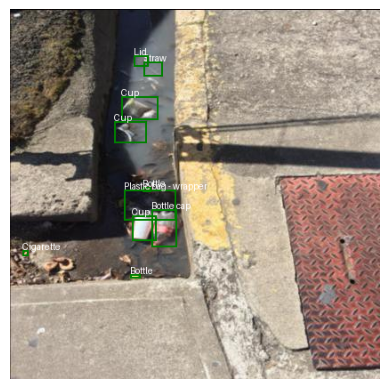

In [15]:
def draw_bounding_box(img_path):
    # Load the image using PIL
    img = Image.open(img_path)
    img_width, img_height = img.size

    # Create a drawing object
    draw = ImageDraw.Draw(img)

    for _, row in df.loc[df.img_path == img_path].iterrows():
        # Convert YOLO format (center_x, center_y, width, height) to pixel coordinates (x1, y1, x2, y2)
        x1 = int((row.center_x - row.width / 2) * img_width)
        y1 = int((row.center_y - row.height / 2) * img_height)
        x2 = int((row.center_x + row.width / 2) * img_width)
        y2 = int((row.center_y + row.height / 2) * img_height)

        # Draw the bounding box
        draw.rectangle([x1, y1, x2, y2], outline="green", width=2)

        # Add the class name as text
        text = meta["names"][row.class_id]
        draw.text((x1, y1 - 10), text, fill="white")

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()


draw_bounding_box(img_path)

⚠️ There seems to be a labelling error. Could we detect and remove anomalies with machine learning?

In [16]:
# The bounding box area could be an interesting feature to analyze
df["area"] = df.width * df.height

In [17]:
# check the distribution for the classes with a boxplot
px.box(df, x="class_name", y="area", title="Bounding Box Area Distribution by Class")

In [18]:
# using a log scale for the y-axis
px.box(
    df,
    x="class_name",
    y="area",
    title="Bounding Box Area Distribution by Class (log scale)",
    log_y=True,
)

Check the largest example for a cigarette

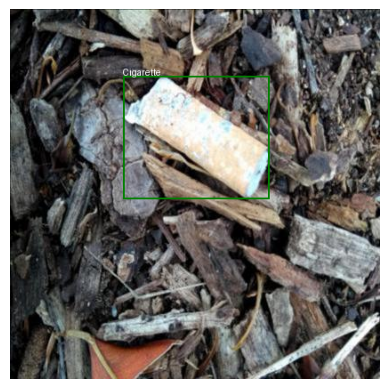

In [19]:
# display the image with the largest bounding box for a cigarette
cigarette = df[df.class_name == "Cigarette"].sort_values(by="area", ascending=False).iloc[0]
img_path = cigarette.img_path

draw_bounding_box(img_path)

So simple area distributions will not work. Perhaps a simple rule system could help: if the same image contains a bottle and a bottle cap, the area of the latter should always be smaller.

In [20]:
# Select all the images with a Bottle and a Bottle cap label
bottle_img_paths = df[df.class_name == "Bottle"].img_path.unique()
bottle_cap_img_paths = df[df.class_name == "Bottle cap"].img_path.unique()
common_img_paths = set(bottle_img_paths).intersection(set(bottle_cap_img_paths))
print(f"Number of images with both Bottle and Bottle cap: {len(common_img_paths)}")

# Select from those instances where any of the Bottle areas is smaller that the largest Bottle cap area
suspect_bottles_img_paths = []
for img_path in common_img_paths:
    # largest Bottle cap:
    max_cap_area = df[(df.img_path == img_path) & (df.class_name == "Bottle cap")].area.max()
    # any Bottle smaller than that?
    suspect_bottle = df[
        (df.img_path == img_path) & (df.class_name == "Bottle") & (df.area < max_cap_area)
    ]
    if len(suspect_bottle) > 0:
        suspect_bottles_img_paths.append(img_path)

print(
    f"Number of images with a Bottle smaller than the largest Bottle cap: {len(suspect_bottles_img_paths)}"
)

Number of images with both Bottle and Bottle cap: 529
Number of images with a Bottle smaller than the largest Bottle cap: 529
Number of images with a Bottle smaller than the largest Bottle cap: 529


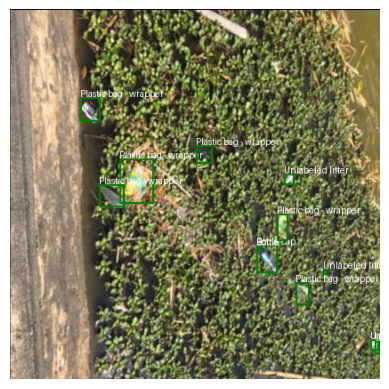

In [21]:
draw_bounding_box(random.choice(suspect_bottles_img_paths))

Could it be that all bottle and bottle cap labels are switched?

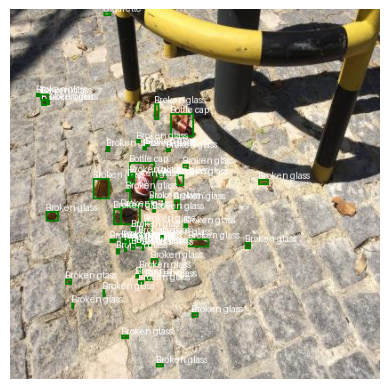

In [22]:
# Select an images with Bottle caps and no Bottles
bottle_cap_no_bottle_img_paths = set(bottle_cap_img_paths).difference(set(bottle_img_paths))

draw_bounding_box(random.choice(list(bottle_cap_no_bottle_img_paths)))

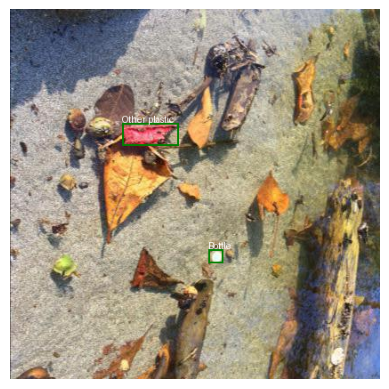

In [23]:
# Select an images with Bottles and no Bottle caps
bottle_no_bottle_cap_img_paths = set(bottle_img_paths).difference(set(bottle_cap_img_paths))

draw_bounding_box(random.choice(list(bottle_no_bottle_cap_img_paths)))

We need to switch the labels in the meta data

In [ ]:
# Swap Bottle cap and Bottle labels
bottle_cap_idx = meta["names"].index("Bottle cap")
bottle_idx = meta["names"].index("Bottle")
meta["names"][bottle_cap_idx], meta["names"][bottle_idx] = (
    meta["names"][bottle_idx],
    meta["names"][bottle_cap_idx],
)

# Verify the swap
meta["names"]

['Aluminium foil',
 'Bottle',
 'Bottle cap',
 'Broken glass',
 'Can',
 'Carton',
 'Cigarette',
 'Cup',
 'Lid',
 'Other litter',
 'Other plastic',
 'Paper',
 'Plastic bag - wrapper',
 'Plastic container',
 'Pop tab',
 'Straw',
 'Styrofoam piece',
 'Unlabeled litter']